In [153]:
import torch
import random
import numpy as np
from numpy.linalg import det
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import norm
from scipy.stats.distributions import chi2
from random import shuffle
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky

## Creating Dataset

In [82]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [83]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [84]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [85]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()

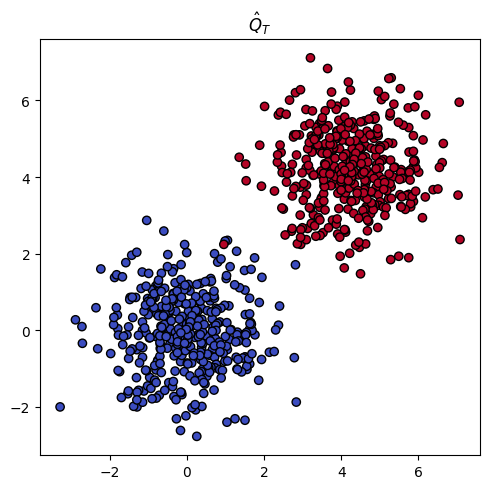

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

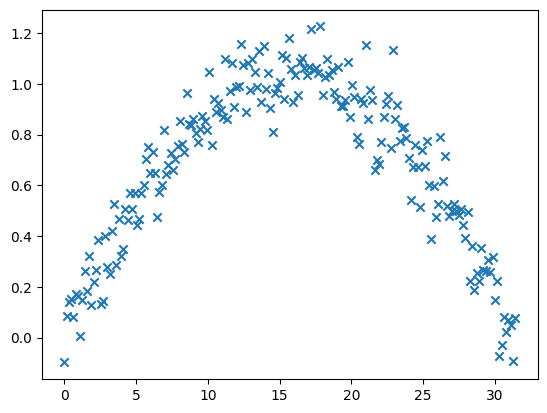

In [87]:
abs = np.linspace(0, 10*np.pi, 200)
np.random.seed(None)
def arc(x):
    return np.sin(x/10) + np.random.normal(0.05, 0.1, 200)

X_arc = np.concatenate((abs.reshape((200, 1)), arc(abs).reshape((200, 1))), axis=1)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_arc[:, 0], X_arc[:, 1], marker = 'x')

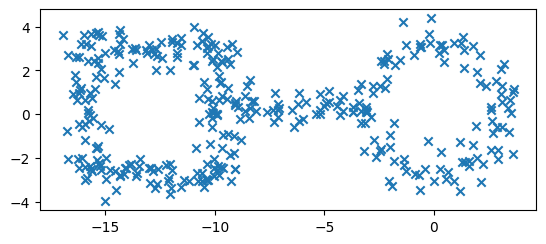

In [217]:
# Number of data points for each component
num_points = 100

# Generate data for a ring
radius = 3
theta_ring = np.linspace(0, 2 * np.pi, num_points)
ring_x = radius * np.cos(theta_ring)
ring_y = radius * np.sin(theta_ring)

# Define the side length of the square
side_length = 6

# Generate points for all sides of the square

# Generate points for the bottom side of the square
bottom_x = np.linspace(-10 - side_length, -10, num_points//2)
bottom_y = np.full(num_points//2, -side_length / 2)

# Generate points for the top side of the square
top_x = np.linspace(-10 - side_length, -10, num_points//2)  # Reversed order
top_y = np.full(num_points//2, side_length / 2)

# Generate points for the left side of the square
left_x = np.full(num_points//2, -10 - side_length)
left_y = np.linspace(-side_length / 2, side_length / 2, num_points//2)

# Generate points for the right side of the square
right_x = np.full(num_points//2, -10)
right_y = np.linspace(side_length / 2, -side_length / 2, num_points//2)  # Reversed order

# Combine all points to create the square dataset
square_x = np.concatenate((bottom_x, right_x, top_x, left_x))
square_y = np.concatenate((bottom_y, right_y, top_y, left_y))

# Generate data for a connecting line
line_x = np.linspace(-3, -10, num_points//2)
line_y = np.zeros(num_points//2)

# Combine the datasets
x = np.concatenate((ring_x, square_x, line_x))
y = np.concatenate((ring_y, square_y, line_y))

x += np.random.normal(0.2, 0.5, len(x))
y += np.random.normal(0.2, 0.5, len(y))

X_ring_and_square = np.concatenate((x.reshape((len(x), 1)), y.reshape((len(y), 1))), axis=1)

plt.scatter(x, y, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Python Implementation of Incremental Learning based on Growing Gaussian Mixture Models

Global variables

In [89]:
a = 0.8

Utility functions

In [249]:
def mahalanobis(x, gauss):
    return np.sqrt(np.dot(np.dot((x - gauss[2]), np.linalg.inv(gauss[3])), (x - gauss[2])))


def plot_GMM(GMM, fig, ax):

    for i in range(len(GMM)):
        # Define the mean and covariance matrix
        mean = GMM[i][2]
        cov_matrix = GMM[i][3]

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Calculate the angle of rotation for the ellipse
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # Plot the mean of the gaussian
        ax.scatter(mean[0], y=mean[1], marker = 'x', color='g', zorder=2)

        # Create and add the ellipse to the plot
        ellipse = patches.Ellipse(xy=mean, width=2 * np.sqrt(5.991 * eigenvalues[0]), height=2 * np.sqrt(5.991 * eigenvalues[1]),
                                angle=angle, fill=False, color='b')
        ax.add_patch(ellipse)

        # Set axis limits and labels
        ax.set_xlim(xmin-5, xmax+5)
        ax.set_ylim(ymin-3, ymax+3)

def kld(GMMi, GMMj):
    d = 1/2 * (np.log(det(GMMj[3])/det(GMMi[3])) + np.trace(np.dot(np.linalg.inv(GMMj[3]), GMMi[3]))
                                   - np.dot(np.dot((GMMj[2] - GMMi[2]).reshape((1, len(GMMj[2]))), np.linalg.inv(GMMi[3])), 
                                            (GMMj[2] - GMMi[2]).reshape((len(GMMj[2]), 1)))
                                    - len(GMMj[2]))
    return d[0, 0]

def split(gauss):
    eigenvalues, eigenvectors = np.linalg.eigh(gauss[3])
    lamb_i = np.argmax(eigenvalues)
    nu = eigenvectors[:, lamb_i]
    delta_nu = np.sqrt(a*eigenvalues[lamb_i]) * nu
    tau = gauss[0]/2
    c = gauss[1]/2
    mu1 = gauss[2] + delta_nu
    mu2 = gauss[2] - delta_nu
    sigma = gauss[3] - np.dot(delta_nu.reshape((len(delta_nu), 1)), delta_nu.reshape((1, len(delta_nu))))
    return [tau, c, mu1, sigma], [tau, c, mu2, sigma]

def merge(gauss1, gauss2):
    merged_weight = gauss1[0] + gauss2[0]
    merged_c = gauss1[1] + gauss2[1] - 1
    f1 = gauss1[0]/merged_weight
    f2 = gauss2[0]/merged_weight
    merged_mean = f1 * gauss1[2] + f2 * gauss2[2]
    merged_cov = f1 * gauss1[3] + f2 * gauss2[3] \
                + f1 * f2 * np.outer(gauss1[2] - gauss2[2], gauss1[2] - gauss2[2])
    #merged_cov = nearest_psd(merged_cov)
    merged_gauss = [merged_weight, merged_c, merged_mean, merged_cov]
    return merged_gauss

def sqrtm(A, return_inv=False):
    D, V = torch.linalg.eig(A)

    A_sqrt = torch.mm(V, torch.mm(torch.diag(D.pow(1 / 2)), V.T)).real
    if return_inv:
        A_sqrt_neg = torch.mm(V, torch.mm(torch.diag(D.pow(-1 / 2)), V.T)).real
        return A_sqrt, A_sqrt_neg
    return A_sqrt

def bures_wasserstein_metric(mean1, mean2, cov1, cov2):
    sqrt_src_cov = sqrtm(cov1)

    M = sqrtm(torch.mm(sqrt_src_cov, torch.mm(cov2, sqrt_src_cov)))
    bures_metric = torch.trace(cov1) + torch.trace(cov2) - 2 * torch.trace(M)

    return torch.sqrt(torch.dist(mean1, mean2, p=2) ** 2 + bures_metric)

def nearest_psd(M):
    try:
        cholesky_decomp = cholesky(M, lower=True)
        nearest_psd = np.dot(cholesky_decomp, cholesky_decomp.T)
        return nearest_psd
    except np.linalg.LinAlgError:
        # If Cholesky decomposition fails, add regularization
        eigval, eigvec = np.linalg.eigh(M)
        nearest_psd = np.dot(eigvec, np.dot(np.diag(np.maximum(eigval, 0)), eigvec.T))
        return nearest_psd

In [246]:
def GGMM(X, K_max, sigma0, alpha, T_sigma):
    GMM = []
    d = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            d.append(mahalanobis(new_x, GMM[j]))
            if mahalanobis(new_x, GMM[j]) < T_sigma:
                P[j] = GMM[j][0] * multivariate_normal(mean=GMM[j][2], cov=GMM[j][3]).pdf(new_x)
            else:
                P[j] = 0
        R = [j for j in range(len(P)) if P[j] > 0]
        create_gaussian = R == []
        if create_gaussian:
            if len(GMM) < K_max:
                GMM.append([alpha, 1, new_x, sigma0])
            else:
                m = np.argmin([GMM[j][0] for j in range(len(GMM))])
                for j in range(len(GMM)):
                    GMM[j][0] = (1 - alpha) * GMM[j][0]
                GMM[m] = [alpha, 1, new_x, sigma0]
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.dot((new_x - GMM[j][2]).reshape((len(new_x), 1)), 
                                                                             (new_x - GMM[j][2]).reshape((1, len(new_x))))
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight        
            
    print(np.max(d))
    print(np.mean(d))
    return GMM


def GGMM_v2(X, K_max, sigma0, alpha, T_split):
    GMM = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            GMM[j][3] = nearest_psd(GMM[j][3])
            P[j] = GMM[j][0] * multivariate_normal(mean=GMM[j][2], cov=GMM[j][3], allow_singular=True).pdf(new_x)
        if len(GMM) < K_max:
            GMM.append([alpha, 1, new_x, sigma0])
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.outer(new_x - GMM[j][2], new_x - GMM[j][2])
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight
        
        # Split and merge
        if len(GMM) > 0:
            
            # Split
            V = [np.linalg.det(GMM[j][3]) for j in range(len(GMM))]
            s = np.argmax(V)
            print('split: ', V[s])
            if V[s] > T_split:
                gauss_split1, gauss_split2 = split(GMM[s])
                del GMM[s]
                GMM.append(gauss_split1)
                GMM.append(gauss_split2)
            
            # Merge
            bwm = np.full((len(GMM), len(GMM)), np.inf)
            for i in range(len(GMM)):
                for j in range(i):
                    gauss1 = GMM[i]
                    gauss2 = GMM[j]
                    mean1 = torch.from_numpy(gauss1[2]).float()
                    mean2 = torch.from_numpy(gauss2[2]).float()
                    cov1 = torch.from_numpy(gauss1[3]).float()
                    cov2 = torch.from_numpy(gauss2[3]).float()
                    bwm[i, j] = bures_wasserstein_metric(mean1, mean2, cov1, cov2)
            min_value = np.min(bwm) 

            while len(GMM) > K_max:
                bwm = np.full((len(GMM), len(GMM)), np.inf)
                for i in range(len(GMM)):
                    for j in range(i):
                        gauss1 = GMM[i]
                        gauss2 = GMM[j]
                        mean1 = torch.from_numpy(gauss1[2]).float()
                        mean2 = torch.from_numpy(gauss2[2]).float()
                        cov1 = torch.from_numpy(gauss1[3]).float()
                        cov2 = torch.from_numpy(gauss2[3]).float()
                        bwm[i, j] = bures_wasserstein_metric(mean1, mean2, cov1, cov2)
                min_value = np.min(bwm)
                print('merge: ', min_value)
                min_indexes = np.argwhere(bwm == min_value)[0]
                merged_gauss = merge(GMM[min_indexes[0]], GMM[min_indexes[1]])
                del GMM[max(min_indexes[0], min_indexes[1])]
                del GMM[min(min_indexes[0], min_indexes[1])]
                GMM.append(merged_gauss)   
        
            
    return GMM

In [92]:
def GGMM_s_m(X, K_max, sigma0, alpha, T_sigma, T_split, T_merge):
    GMM = []
    d = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            d.append(mahalanobis(new_x, GMM[j]))
            if mahalanobis(new_x, GMM[j]) < T_sigma:
                P[j] = GMM[j][0] * multivariate_normal(mean=GMM[j][2], cov=GMM[j][3]).pdf(new_x)
            else:
                P[j] = 0
        R = [j for j in range(len(P)) if P[j] > 0]
        create_gaussian = R == []
        if create_gaussian:
            if len(GMM) < K_max:
                GMM.append([alpha, 1, new_x, sigma0])
            else:
                m = np.argmin([GMM[j][0] for j in range(len(GMM))])
                for j in range(len(GMM)):
                    GMM[j][0] = (1 - alpha) * GMM[j][0]
                GMM[m] = [alpha, 1, new_x, sigma0]
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.dot((new_x - GMM[j][2]).reshape((len(new_x), 1)), 
                                                                             (new_x - GMM[j][2]).reshape((1, len(new_x))))
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight
        

        # Split and merge
        if len(GMM) > 0:
            
            # Split
            V = [np.linalg.det(GMM[j][3]) for j in range(len(GMM))]
            s = np.argmax(V)
            print('split: ', V[s])
            if V[s] > T_split:
                gauss_split1, gauss_split2 = split(GMM[s])
                del GMM[s]
                GMM.append(gauss_split1)
                GMM.append(gauss_split2)
            
            # Merge
            skld = np.full((len(GMM), len(GMM)), np.inf)
            for i in range(len(GMM)):
                for j in range(i):
                    skld[i, j] = 1/2*(kld(GMM[i], GMM[j]) + kld(GMM[j], GMM[i]))
            min_value = np.min(skld)
            print('merge: ', min_value)
            if min_value < T_merge:
                min_indexes = np.argwhere(skld == min_value)[0]
                merged_gauss = merge(GMM[min_indexes[0]], GMM[min_indexes[1]])
                del GMM[max(min_indexes[0], min_indexes[1])]
                del GMM[min(min_indexes[0], min_indexes[1])]
                GMM.append(merged_gauss)
        

    return GMM

split:  0.9310528524292091
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
split:  0.9310528524292093
merge:  0.21009427309036255
split:  0.5512377484752041
split:  0.5512377484752038
split:  0.5512377484752038
split:  0.5512377484752038
split:  1.4580403233998784
merge:  0.5754439830780029
split:  0.29508196200964376
split:  1.8837463919935549
merge:  0.6665652990341187
split:  1.055266702855954
merge:  0.829249382019043
split:  0.9611878680943802
merge:  1.1225508451461792
split:  0.6220078674452417
split:  1.5202755813886581
merge:  1.254010558128357
split:  1.5000846712583233
merge:  1.3294696807861328
split:  1.2933619247315613
merge:  1.6813454627990723
split:  0.7298225440024694
split:  0.809096364835873
split:  0.8090963648358729
split:  0.8456996491026145
split:  0.8456996491026149
split:  0.8460098580955004
split:  0.8460098580955525
spl

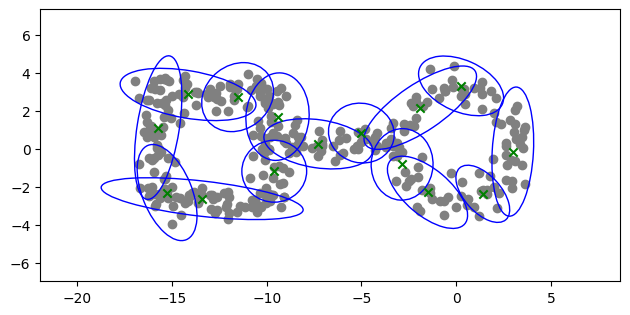

In [296]:
data = np.random.permutation(X_ring_and_square)

xmin, ymin = np.min(data, axis=0)[0], np.min(data, axis=0)[1]
xmax, ymax = np.max(data, axis=0)[0], np.max(data, axis=0)[1]

K_max = 15
cov_init_size = (xmax-xmin + ymax-ymin)/(2*K_max)
cov_init = cov_init_size*np.eye(2)
T_split = np.linalg.det(cov_init_size*np.eye(2))
result = GGMM_v2(data, K_max, cov_init, 0.1, T_split)
#result = GGMM_s_m(data, 2, np.eye(2)/1, 0.1, 10, 3, 1)


fig, ax = plt.subplots()

ax.scatter(x=data[:, 0], y=data[:, 1], color='grey', zorder = 1)
plot_GMM(result, fig, ax)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

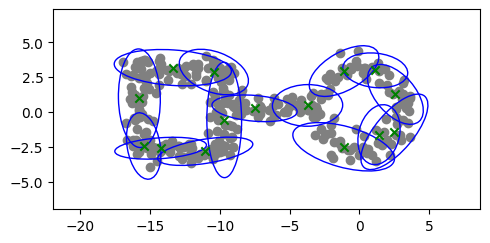

In [260]:
fig, ax = plt.subplots()

ax.scatter(x=data[:, 0], y=data[:, 1], color='grey', zorder = 1)
plot_GMM(result, fig, ax)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()